# Canny Edge Detection

The Canny edge detection algorithm is a multistage process that helps to identify the edges in an image by reducing noise and preserving important edge features.

Ref: https://www.educative.io/answers/what-is-canny-edge-detection

### Step 1: Grayscale conversion

The first step in the Canny edge detection algorithm is to convert the input image into grayscale. Grayscale images have a single channel representing the intensity of each pixel, which simplifies the edge detection process and reduces computational complexity. Grayscale conversion removes the color information from the image while preserving the relative brightness levels.


In [10]:
# Load and convert image to grayscale
from PIL import Image

Grayscale_image = Image.open('Test_Images\Grayscale_image.jpg').convert('L')


<>:4: SyntaxWarning: invalid escape sequence '\G'
<>:4: SyntaxWarning: invalid escape sequence '\G'
C:\Users\meetb\AppData\Local\Temp\ipykernel_50364\517321616.py:4: SyntaxWarning: invalid escape sequence '\G'
  Grayscale_image = Image.open('Test_Images\Grayscale_image.jpg').convert('L')


### Step 2: Noise reduction

The first step in the Canny edge detection algorithm is to apply a Gaussian filter to the input image. The Gaussian filter is a smoothing operation that helps to reduce noise in the image. Noise can introduce false edges, which could compromise the accuracy of the edge detection process. The Gaussian filter smooths the image by convolving it with a Gaussian kernel, effectively reducing high-frequency noise while preserving the edges’ sharpness.

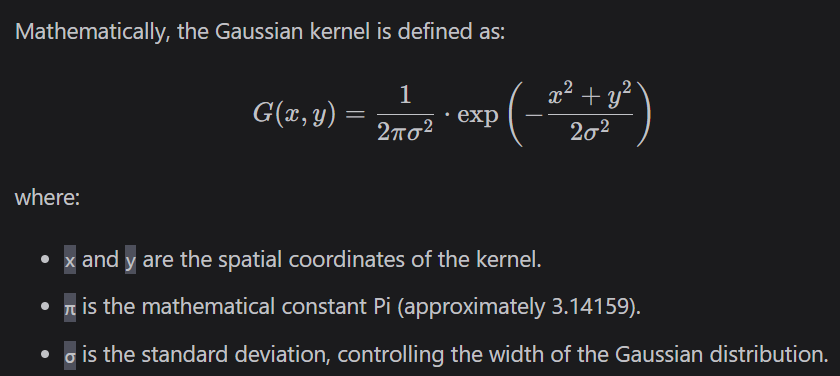


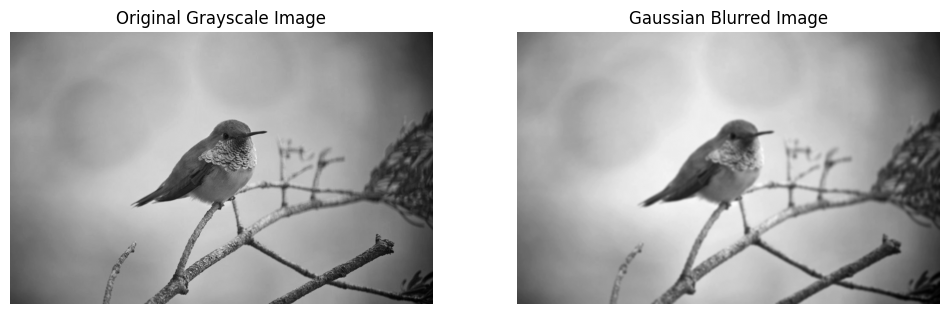

In [11]:
# Noise Reduction using Gaussian Blur
from PIL import ImageFilter
Gaussian_blurred_image = Grayscale_image.filter(ImageFilter.GaussianBlur(radius=2))
# Display the original and blurred images
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Grayscale_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Gaussian_blurred_image, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.axis('off')
plt.show()


### Step 3: Gradient calculation

After reducing noise, the Canny algorithm proceeds to compute the gradient of the smoothed image. The gradient measures how fast the intensity changes at each pixel’s location. The algorithm uses the concept of derivatives, typically the Sobel operator, to determine both the gradient magnitude and orientation for each pixel. The gradient magnitude indicates the strength of the intensity change, while the gradient orientation specifies the direction of the steepest change.

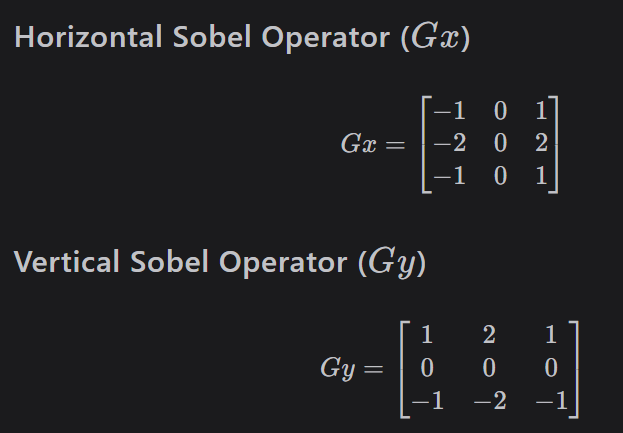

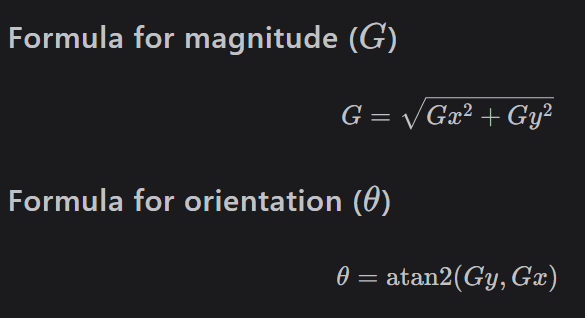



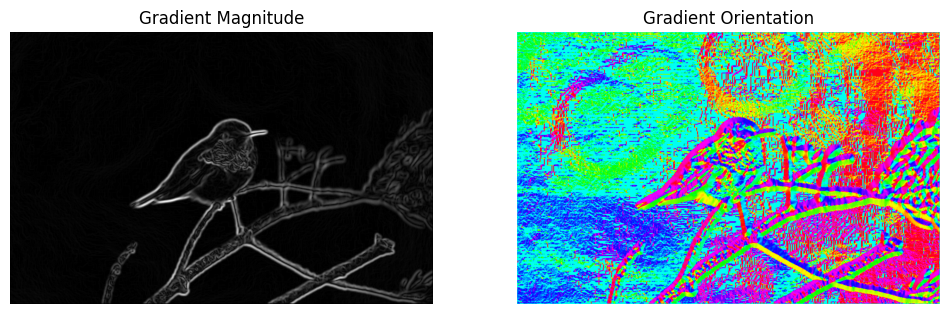

In [12]:
# Gradient Calculation using Sobel Operator
import numpy as np
from scipy.ndimage import convolve
# Define Sobel filters for gradient calculation
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])
# Compute Gradient using Hardman Product of Sobel filters
def compute_gradient(image, sobel_x, sobel_y):
    gradient_x = np.zeros_like(image, dtype=float)
    gradient_y = np.zeros_like(image, dtype=float)

    # Apply Sobel filters
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            region = image[i-1:i+2, j-1:j+2]
            gradient_x[i, j] = np.sum(region * sobel_x)
            gradient_y[i, j] = np.sum(region * sobel_y)

    return gradient_x, gradient_y
# Compute gradients
gradient_x, gradient_y = compute_gradient(np.array(Gaussian_blurred_image), sobel_x, sobel_y)
# Calculate gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)
# Display the gradient magnitude and orientation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gradient_orientation, cmap='hsv')
plt.title('Gradient Orientation')
plt.axis('off')
plt.show()



### Step 4: Non-maximum suppression

This step effectively thins out the edges and produces a cleaner representation of the actual edges in the image.

Non-maximum suppression in the Canny edge detection algorithm works by examining each pixel's gradient magnitude and orientation and comparing it with the neighboring pixels along the gradient direction. If the central pixel's gradient magnitude is the largest among its neighbors, it means that this pixel is likely part of an edge, and we keep it. If not, we suppress it by setting its intensity to zero and removing it from consideration as an edge pixel.

In [13]:
import numpy as np

def non_max_suppression(magnitude, direction):
    M, N = magnitude.shape
    output = np.zeros((M, N), dtype=np.float32)

    # Convert radians to degrees
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180  # Ensure angles are between 0 and 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255

            # Direction 0° (horizontal): neighbors at left and right
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]

            # Direction 45°: neighbors at top-right and bottom-left
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]

            # Direction 90° (vertical): neighbors at top and bottom
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]

            # Direction 135°: neighbors at top-left and bottom-right
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            # Keep the pixel only if it's greater than both neighbors
            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                output[i,j] = magnitude[i,j]
            else:
                output[i,j] = 0

    return output


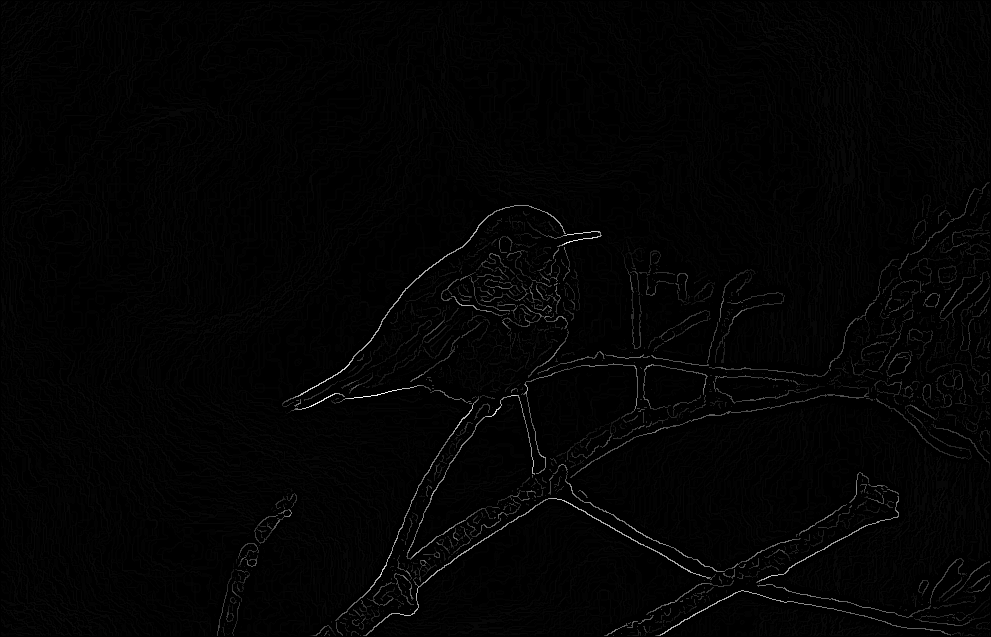

In [14]:
# Assume you already have magnitude and direction
nms_result = non_max_suppression(gradient_magnitude, gradient_orientation)

# Normalize for viewing
nms_normalized = (nms_result / nms_result.max()) * 255
nms_image = Image.fromarray(nms_normalized.astype(np.uint8))
nms_image.save("nms_output.jpg")
nms_image


### Step 5: Double thresholding

A high threshold and a low threshold are used for this purpose.

- Pixels with gradient magnitudes above the high threshold are considered strong edges, indicating significant intensity changes.

- Pixels with gradient magnitudes between low threshold and high threshold are classified as weak edges. These weak edges may represent real edges or noise, and they need further verification.

- Pixels with gradient magnitudes below the low threshold are considered non-edges and are discarded.

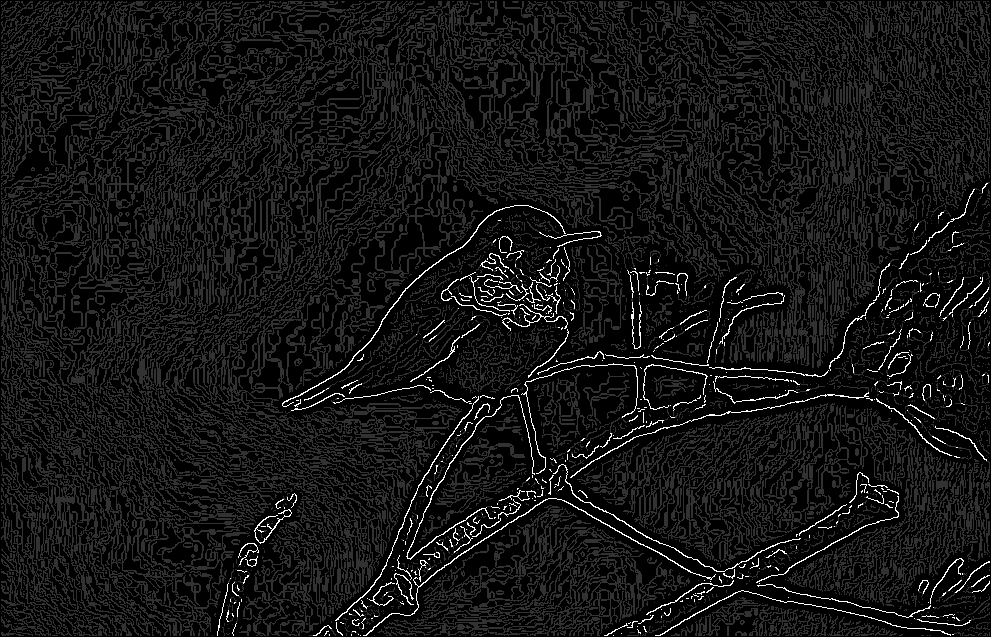

In [15]:
def double_threshold(image, low_ratio=0.05, high_ratio=0.15):
    high_threshold = image.max() * high_ratio
    low_threshold = high_threshold * low_ratio

    strong = 255
    weak = 50

    result = np.zeros_like(image, dtype=np.uint8)

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result, weak, strong

# Apply double thresholding
thresholded_image, weak, strong = double_threshold(nms_result)
# Normalize for viewing
thresholded_image = Image.fromarray(thresholded_image.astype(np.uint8))
thresholded_image

### Step 6: Edge tracking by hysteresis

The last step of the Canny edge detection algorithm is edge tracking by hysteresis. Hysteresis means 'remembering the past' to make our edges more accurate and reliable. This step aims to link weak edges that are likely part of real edges to the strong edges. Starting from each strong edge pixel, the algorithm traces the edge by considering its neighboring weak edge pixels that are connected. If a weak edge pixel is connected to a strong edge pixel, it is also considered part of the edge and retained. This process continues until no more weak edges are connected. This ensures that the edges are continuous and well-defined.

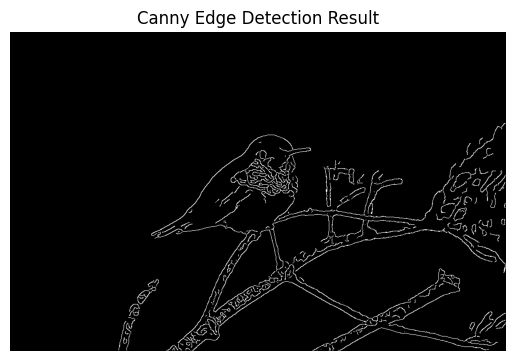

In [23]:
from PIL import Image
import numpy as np

def hysteresis(image, weak=50, strong=255):
    M, N = image.shape
    result = image.copy()

    for i in range(1, M-1):
        for j in range(1, N-1):
            if result[i, j] == weak:
                # Check 8-connected neighbors
                if ((result[i+1, j-1] == strong) or (result[i+1, j] == strong) or (result[i+1, j+1] == strong)
                    or (result[i, j-1] == strong) or (result[i, j+1] == strong)
                    or (result[i-1, j-1] == strong) or (result[i-1, j] == strong) or (result[i-1, j+1] == strong)):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
    return result

# Assuming thresholded_image is defined
weak = 50
strong = 255
thresholded_array = np.array(thresholded_image)
final_edge_map = hysteresis(thresholded_array, weak, strong)


# Ensure grayscale mode for saving
final_image = Image.fromarray(final_edge_map.astype(np.uint8), mode='L')
final_image.save("canny_final.jpg")

# Display the final edge map
import matplotlib.pyplot as plt
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.title('Canny Edge Detection Result')
plt.show()

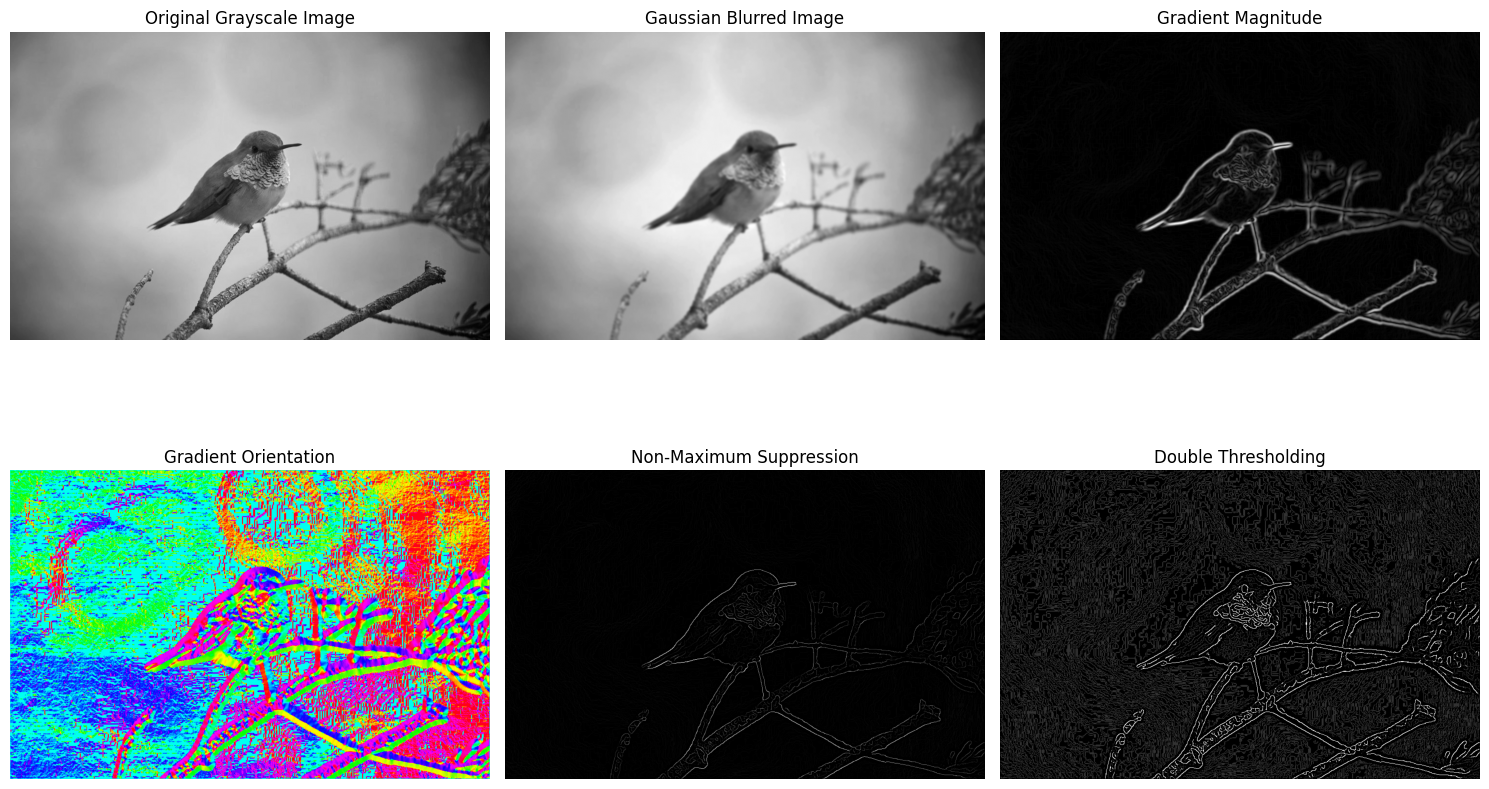

In [24]:
# Step buy step comparision of all the images 
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(Grayscale_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(Gaussian_blurred_image, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(gradient_orientation, cmap='hsv')
plt.title('Gradient Orientation')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(nms_image, cmap='gray')
plt.title('Non-Maximum Suppression')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(thresholded_image, cmap='gray')
plt.title('Double Thresholding')
plt.axis('off')
plt.tight_layout()
plt.show()